# Example: word classification with single spectrogram
Experimental notebook by @ste

In this notebook I'll focus on the importance of **LOOK** and **HEAR** your augmented sound data, to understand if the amount of transformation you're going to apply are messing up or not your original data.

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [3]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms
import pandas as pd

In [5]:
#Options
pd.set_option('display.max_colwidth', -1)

## Preparing the data

We're going to do **phoneme classification** using the TIMIT dataset.

The copyright on TIMIT isn't clear, and the data is hard to download, so we assume that the user has access to this dataset.

**IMPORTANT:** the dataset should be located in the standard fast.ai location:
> $HOME/.fastai/data/timit

In [6]:
#Fast.ai way to get folder for your dataset
path = datapath4file('timit')

### Parsing the data

In [7]:
def extractInformationsFromAbsolutePath(s: str):
    items = list(filter(lambda x: len(x)>0,s.split('/')))
    USAGE = items[0]
    DIALECT = items[1]
    SEX = items[2][0]
    SPEAKER_ID = items[2][1:]
    SENTENCE_ID = items[3]
    return USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID
    
def test_extractInformationsFromAbsolutePath():
    USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath('/TRAIN/DR7/MPAR0/SI2206')
    assert 'TRAIN'==USAGE
    assert 'DR7'==DIALECT
    assert 'M'==SEX
    assert 'PAR0'==SPEAKER_ID
    assert 'SI2206'==SENTENCE_ID
    print('TEST PASED')

test_extractInformationsFromAbsolutePath()

TEST PASED


In [8]:
def extractTimitDatasetInformation(path):
    '''Put in a dataframe all the information about samples'''
    import glob
    files = glob.glob(str(path)+ '/**/*.WAV', recursive=True)
    ret = pd.DataFrame(files, columns=['relPath'])
    #Remove path and extension
    ret['relPath'] = ret['relPath'].apply(lambda x: x.replace(str(path),'').replace('.WAV',''))

    def extractIntoSeries(s):
        USAGE, DIALECT, SEX, SPEAKER_ID, SENTENCE_ID = extractInformationsFromAbsolutePath(s)
        return pd.Series({
            'USAGE': USAGE,
            'DIALECT': DIALECT,
            'SEX': SEX,
            'SPEAKER_ID': SPEAKER_ID,
            'SENTENCE_ID': SENTENCE_ID,
            'IDX': SEX + SPEAKER_ID + ':' + SENTENCE_ID})

    #IMPORTANT: Apply multiple transformations at one
    ret = ret.merge(ret['relPath'].apply(lambda s: extractIntoSeries(s)), left_index=True, right_index=True)    
    ret = ret.set_index(['IDX']) # Add index
    return ret
                
all_files_df = extractTimitDatasetInformation(path)
all_files_df.head()

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MPAR0:SI2206,/TRAIN/DR7/MPAR0/SI2206,TRAIN,DR7,M,PAR0,SI2206
MPAR0:SX316,/TRAIN/DR7/MPAR0/SX316,TRAIN,DR7,M,PAR0,SX316
MPAR0:SI1576,/TRAIN/DR7/MPAR0/SI1576,TRAIN,DR7,M,PAR0,SI1576
MPAR0:SA1,/TRAIN/DR7/MPAR0/SA1,TRAIN,DR7,M,PAR0,SA1
MPAR0:SX46,/TRAIN/DR7/MPAR0/SX46,TRAIN,DR7,M,PAR0,SX46


In [9]:
print(f'Number of files: {len(all_files_df)}')

Number of files: 6300


### OPTIONAL Decimate dataset
To speedup computation we reduce train/valid set.

In [10]:
#DON'T RUN THIS CELL IN YOU WANT TOI USE ALL DATA
def decimate(train_df:pd.DataFrame, valid_df:pd.DataFrame, pct=.1)->pd.DataFrame:
    t1=train_df.sample(frac=pct,random_state=1)
    t2=valid_df.sample(frac=pct,random_state=1)
    return pd.concat([t1,t2],axis=0)

all_files_df=decimate(all_files_df[all_files_df.USAGE=='TRAIN'],all_files_df[all_files_df.USAGE=='TEST'],.1)
all_files_df.groupby(['USAGE'])['relPath'].count()

USAGE
TEST     168
TRAIN    462
Name: relPath, dtype: int64

# Word classification

## Create data bunch

In [11]:
def process_phn_file(idx:str, phn_file, sig, sr, ext, delimiter=' ')->pd.DataFrame:
    df = pd.read_csv(phn_file, delimiter=delimiter, header=None)
    df.columns = ['START', 'END', ext]
    df['SIG'] = df.apply(lambda x : sig[x['START']: x['END']], axis=1)
    df['SR'] = sr
    df['IDX'] = idx
    df['IDXN'] = pd.Series(map(lambda x: idx+':'+str(x), range(len(df))))   
    df = df.set_index(['IDXN'])
    return df

In [12]:
def extractItems(path, idx, relativePath, ext, verbose=False)->pd.DataFrame:
    base_path = str(path) + relativePath
    wav_file = base_path + ".WAV"
    wav_exists = os.path.isfile(wav_file)
    if verbose: print(wav_file, f'\tExists: {wav_exists}')
    #Sanity check
    if not wav_exists: return none
    #Proceed
    sigTwoChannels,sr = torchaudio.load(wav_file)
    sig = sigTwoChannels[0] # MONO NO STEREO - convert to "one dimension"
    phn_file = base_path + '.' + ext
            
    ret = process_phn_file(idx, phn_file, sig, sr, ext, delimiter=' ')
    
    return ret

#    sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
#    df = process_phn_file(phn_file, sig, sr, delimiter=' ')
#    df['Source'] = phn_file
#    final = final.append(df)
            
def test_extractItems_PHN():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'PHN', verbose=True)
    display(ret_df.head(2))
    print(f'Number of rows: {len(ret_df)}')
#    assert 54==len(ret_df)
    print('TEST DONE')

test_extractItems_PHN()

/home/ste/.fastai/data/timit/TRAIN/DR2/MJMD0/SX308.WAV 	Exists: True


,START,END,PHN,SIG,SR,IDX
IDXN,,,,,,
MJMD0:SX308:0,0,2320,h#,"[tensor(0.0001), tensor(0.0002), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0001), tensor(3.0518e-05), tensor(9.1553e-05), tensor(0.), tensor(-3.0518e-05), tensor(-9.1553e-05), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(6.1035e-05), tensor(9.1553e-05), tensor(0.), tensor(0.0002), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(6.1035e-05), tensor(9.1553e-05), tensor(-9.1553e-05), tensor(3.0518e-05), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.), tensor(0.0001), tensor(9.1553e-05), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(6.1035e-05), tensor(9.1553e-05), tensor(6.1035e-05), tensor(6.1035e-05), tensor(0.0002), tensor(0.), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0001), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(9.1553e-05), tensor(3.0518e-05), tensor(9.1553e-05), tensor(-6.1035e-05), tensor(-6.1035e-05), tensor(6.1035e-05), tensor(0.0001), tensor(3.0518e-05), tensor(3.0518e-05), tensor(6.1035e-05), tensor(3.0518e-05), tensor(-6.1035e-05), tensor(-3.0518e-05), tensor(3.0518e-05), tensor(0.0001), tensor(-3.0518e-05), tensor(0.0001), tensor(3.0518e-05), tensor(0.0001), tensor(0.), tensor(3.0518e-05), tensor(0.), tensor(0.), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(9.1553e-05), tensor(3.0518e-05), tensor(0.0002), tensor(0.), tensor(9.1553e-05), tensor(9.1553e-05), tensor(0.0001), tensor(0.0002), tensor(0.0001), tensor(9.1553e-05), ...]",16000,MJMD0:SX308
MJMD0:SX308:1,2320,4803,sh,"[tensor(3.0518e-05), tensor(-0.0002), tensor(-3.0518e-05), tensor(0.0004), tensor(0.0003), tensor(0.0002), tensor(-0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(-0.0004), tensor(0.0002), tensor(0.0006), tensor(0.), tensor(-0.0002), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0005), tensor(-0.0005), tensor(0.0001), tensor(0.0003), tensor(0.0005), tensor(0.0005), tensor(-0.0007), tensor(-0.0005), tensor(0.0007), tensor(0.0005), tensor(-0.0002), tensor(-0.0002), tensor(0.0003), tensor(-0.0001), tensor(-0.0005), tensor(0.0005), tensor(0.0006), tensor(-0.0004), tensor(-0.0003), tensor(-3.0518e-05), tensor(-0.0002), tensor(0.0007), tensor(0.0005), tensor(-0.0007), tensor(-0.0006), tensor(-0.0002), tensor(0.0005), tensor(0.0008), tensor(-0.0002), tensor(-0.0008), tensor(-9.1553e-05), tensor(0.0006), tensor(0.0006), tensor(0.0002), tensor(-0.0003), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-0.0005), tensor(-0.0003), tensor(3.0518e-05), tensor(-0.0004), tensor(-0.0005), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0006), tensor(-0.0005), tensor(-0.0005), tensor(0.), tensor(-0.0002), tensor(0.0004), tensor(0.0005), tensor(-0.0003), tensor(-0.0003), tensor(0.0003), tensor(0.0006), tensor(0.0005), tensor(-0.0002), tensor(-0.0005), tensor(-3.0518e-05), tensor(-3.0518e-05), tensor(0.0005), tensor(-0.0004), tensor(-0.0005), tensor(0.0002), tensor(0.0002), tensor(0.0006), tensor(0.0003), tensor(-0.0004), tensor(-0.0003), tensor(0.0003), tensor(0.0004), tensor(0.0001), tensor(-0.0011), tensor(-0.0003), tensor(0.0006), tensor(0.0005), tensor(0.0009), tensor(0.0004), ...]",16000,MJMD0:SX308


Number of rows: 34
TEST DONE


In [13]:
def test_extractItems_WRD():
    row = all_files_df.iloc[0]
    ret_df = extractItems(path, row.name, row['relPath'], 'WRD', verbose=True)
    display(ret_df.head(1))
    print(f'Number of rows: {len(ret_df)}')
#    assert 14==len(ret_df)
    print('TEST DONE')

test_extractItems_WRD()

/home/ste/.fastai/data/timit/TRAIN/DR2/MJMD0/SX308.WAV 	Exists: True


,START,END,WRD,SIG,SR,IDX
IDXN,,,,,,
MJMD0:SX308:0,2320,11400,shipbuilding,"[tensor(3.0518e-05), tensor(-0.0002), tensor(-3.0518e-05), tensor(0.0004), tensor(0.0003), tensor(0.0002), tensor(-0.0002), tensor(6.1035e-05), tensor(0.0002), tensor(0.0002), tensor(9.1553e-05), tensor(-0.0004), tensor(0.0002), tensor(0.0006), tensor(0.), tensor(-0.0002), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(-0.0005), tensor(-0.0005), tensor(0.0001), tensor(0.0003), tensor(0.0005), tensor(0.0005), tensor(-0.0007), tensor(-0.0005), tensor(0.0007), tensor(0.0005), tensor(-0.0002), tensor(-0.0002), tensor(0.0003), tensor(-0.0001), tensor(-0.0005), tensor(0.0005), tensor(0.0006), tensor(-0.0004), tensor(-0.0003), tensor(-3.0518e-05), tensor(-0.0002), tensor(0.0007), tensor(0.0005), tensor(-0.0007), tensor(-0.0006), tensor(-0.0002), tensor(0.0005), tensor(0.0008), tensor(-0.0002), tensor(-0.0008), tensor(-9.1553e-05), tensor(0.0006), tensor(0.0006), tensor(0.0002), tensor(-0.0003), tensor(-3.0518e-05), tensor(6.1035e-05), tensor(-0.0005), tensor(-0.0003), tensor(3.0518e-05), tensor(-0.0004), tensor(-0.0005), tensor(-6.1035e-05), tensor(9.1553e-05), tensor(0.0003), tensor(0.0006), tensor(-0.0005), tensor(-0.0005), tensor(0.), tensor(-0.0002), tensor(0.0004), tensor(0.0005), tensor(-0.0003), tensor(-0.0003), tensor(0.0003), tensor(0.0006), tensor(0.0005), tensor(-0.0002), tensor(-0.0005), tensor(-3.0518e-05), tensor(-3.0518e-05), tensor(0.0005), tensor(-0.0004), tensor(-0.0005), tensor(0.0002), tensor(0.0002), tensor(0.0006), tensor(0.0003), tensor(-0.0004), tensor(-0.0003), tensor(0.0003), tensor(0.0004), tensor(0.0001), tensor(-0.0011), tensor(-0.0003), tensor(0.0006), tensor(0.0005), tensor(0.0009), tensor(0.0004), ...]",16000,MJMD0:SX308


Number of rows: 6
TEST DONE


In [14]:
all_files_df.head(2)

,relPath,USAGE,DIALECT,SEX,SPEAKER_ID,SENTENCE_ID
IDX,,,,,,
MJMD0:SX308,/TRAIN/DR2/MJMD0/SX308,TRAIN,DR2,M,JMD0,SX308
FLEH0:SI2311,/TRAIN/DR7/FLEH0/SI2311,TRAIN,DR7,F,LEH0,SI2311


In [15]:
all_files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, MJMD0:SX308 to FCAU0:SX317
Data columns (total 6 columns):
relPath        630 non-null object
USAGE          630 non-null object
DIALECT        630 non-null object
SEX            630 non-null object
SPEAKER_ID     630 non-null object
SENTENCE_ID    630 non-null object
dtypes: object(6)
memory usage: 34.5+ KB


In [16]:
def createItemsDataFrame(path, files_df, ext):
    ret = pd.DataFrame()
    for i,row in files_df.iterrows():
        tmp_df = extractItems(path, row.name, row['relPath'], ext)
        ret = ret.append(tmp_df)
        #print(len(ret))
#    ret = files_df.apply(lambda row: ret.append(extractWords(path, row.name, row['relPath']), ignore_index=True), axis=1)
#    files_df.apply(lambda row: print(row), axis=1)
    return ret

def test_createItemsDataFrame():
    tdf = createItemsDataFrame(path, all_files_df.head(10), 'WRD')
    print(f'Rows: {len(tdf)}')
    tdf.info()
#    assert 86==len(tdf)

test_createItemsDataFrame()

Rows: 80
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, MJMD0:SX308:0 to MADD0:SI538:4
Data columns (total 6 columns):
START    80 non-null int64
END      80 non-null int64
WRD      80 non-null object
SIG      80 non-null object
SR       80 non-null int64
IDX      80 non-null object
dtypes: int64(3), object(3)
memory usage: 4.4+ KB


In [17]:
%time all_words_df = createItemsDataFrame(path, all_files_df, 'WRD')
all_words_df.info()

CPU times: user 18.3 s, sys: 278 ms, total: 18.6 s
Wall time: 3.1 s
<class 'pandas.core.frame.DataFrame'>
Index: 5454 entries, MJMD0:SX308:0 to FCAU0:SX317:7
Data columns (total 6 columns):
START    5454 non-null int64
END      5454 non-null int64
WRD      5454 non-null object
SIG      5454 non-null object
SR       5454 non-null int64
IDX      5454 non-null object
dtypes: int64(3), object(3)
memory usage: 298.3+ KB


In [18]:
print(f'Words count: {len(all_words_df)}')

Words count: 5454


## Join data and create "src" 

In [19]:
#Join files with words
src = all_words_df.merge(all_files_df,left_on='IDX',right_on='IDX')
assert len(src)==len(all_words_df)

In [20]:
#Optionally subsample and ensure good distribution among train and "valid"
#src = src.sample(5000, random_state=1) # Uncomment this to reduce dataset
src.groupby(['USAGE'])['SIG'].count()

USAGE
TEST     1462
TRAIN    3992
Name: SIG, dtype: int64

In [21]:
wrd_freq = src.groupby(['WRD'])['SIG'].count().reset_index(name='FREQ')
wrd_freq.head()

,WRD,FREQ
0,'em,1
1,a,119
2,abbreviate,1
3,abdomen,1
4,ability,1


In [22]:
#Add word frequency measure to src
src = src.merge(wrd_freq,left_on='WRD',right_on='WRD')
assert len(src)==len(all_words_df) # does not pass if src is reduced

In [23]:
# Keep high frequency words
#src = src[src.FREQ>=8]
print(len(src))

5454


In [24]:
#Create merged column...
src['SampleAndSr'] = src.apply(lambda row: (row.SIG,row.SR),axis=1)
src.iloc[0]['SampleAndSr']

(tensor([ 3.0518e-05, -2.1362e-04, -3.0518e-05,  ...,  8.2397e-04,
          2.3499e-03,  2.9297e-03]), 16000)

In [25]:
#Create validation set column from "test" hold out
src['is_valid'] = src['USAGE'].apply(lambda x: not (x=='TRAIN'))
src.groupby(['is_valid'])['SIG'].count()

is_valid
False    3992
True     1462
Name: SIG, dtype: int64

In [26]:
#Count unique words
len(src.WRD.unique())

1800

#### Useful statistics

In [27]:
src['LENGHT'] = src.SIG.apply(lambda x: x.shape[0])
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')

Shortest item: 0
Longest item: 17560


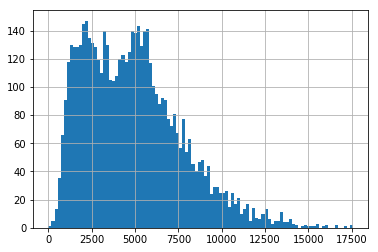

In [28]:
src['LENGHT'].hist(bins=100)

**WARNING** there are zero lenght items that should be filtered...

In [29]:
#Discarding too short and too long sounds
min_duration = 50 # in samples
max_duration = 16000
src = src[src.LENGHT>min_duration]
src = src[src.LENGHT<=max_duration]
print(f'Shortest item: {src.LENGHT.min()}')
print(f'Longest item: {src.LENGHT.max()}')
print(f'Number of items: {len(src)}')

Shortest item: 231
Longest item: 15938
Number of items: 5446


## Classify words

## Data Augmentation

Support functions:

In [30]:
def applyAllTfms(ad:AudioData, tfms):
    '''Recursively apply all tfms'''
    ret = ad
    for tfm in tfms:
        ret = tfm(ret)
    return ret

In [31]:
def displayAudioData(lbl, ad:AudioData, orig:AudioData=None,show=True):
    display(lbl, Audio(ad.sig,rate=ad.sr))
    if show:
        if orig is not None: plt.plot(orig.sig, 'r')
        if ad is not None: plt.plot(ad.sig, 'b')

In [32]:
def get_audio_transforms(spectro:bool=False,
                         white_noise:bool=True,
                         modulate_volume:bool=True,
                         random_cutout:bool=True,
                         pad_with_silence:bool=True,
                         pitch_warp:bool=True,
                         down_and_up:bool=True,
                         mx_to_pad:int=1000,
                         xtra_tfms:Optional[Collection[Transform]]=None,
                         **kwargs)->Collection[Transform]:
    "Utility func to easily create a list of audio transforms."
    res = []
    if white_noise: res.append(partial(tfm_add_white_noise, **kwargs))
    if modulate_volume: res.append(partial(tfm_modulate_volume, **kwargs))
    if random_cutout: res.append(partial(tfm_random_cutout, pct_to_cut=.15, **kwargs))
    if pad_with_silence: res.append(partial(tfm_pad_with_silence, pct_to_pad=.15, min_to_pad=None, max_to_pad=None, **kwargs))
    if pitch_warp: res.append(partial(tfm_pitch_warp, shift_by_pitch=None, bins_per_octave=12, **kwargs))
    if down_and_up: res.append(partial(tfm_down_and_up, sr_divisor=2, **kwargs))
    res.append(partial(tfm_pad_to_max, mx=mx_to_pad))
    final_transform = tfm_extract_signal
    if spectro: final_transform = tfm_spectro
    res.append(final_transform)
    #       train                   , valid
    return (res + listify(xtra_tfms), [partial(tfm_pad_to_max, mx=mx_to_pad), final_transform])

In [33]:
#Data Augmentation
tfms = get_audio_transforms(spectro=True,
                            mx_to_pad=max_duration, #1 sec window
                            white_noise=True, noise_scl=1e-3, # Small noise
                            modulate_volume=True, lower_gain=.95, upper_gain=1.05, # Not big volume variation
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False)

Let's try the audio data augmentation.

In [34]:
# Show all train transformations
train_tfms = tfms[0]
train_tfms

[functools.partial(<function tfm_add_white_noise at 0x7faee532d9d8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
 functools.partial(<function tfm_modulate_volume at 0x7faee532da60>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
 functools.partial(<function tfm_pad_to_max at 0x7faee532dd90>, mx=16000),
 <function exp.nb_DataAugmentation.tfm_spectro(ad: exp.nb_AudioCommon.AudioData, sr=16000, to_db_scale=False, n_fft=400, ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128, **kwargs)>]

In [35]:
# Extract "AudioTransformations" for train set
audio_tfms = train_tfms[:-1]
audio_tfms

[functools.partial(<function tfm_add_white_noise at 0x7faee532d9d8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
 functools.partial(<function tfm_modulate_volume at 0x7faee532da60>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
 functools.partial(<function tfm_pad_to_max at 0x7faee532dd90>, mx=16000)]

In [36]:
samples = src.sample(5,random_state=1)
ads = [AudioData(src.iloc[i].SIG,src.iloc[i].SR) for i in range(len(samples))]

In [37]:
s = ads[0]
displayAudioData('original',s,show=False)

'original'

'augmented'

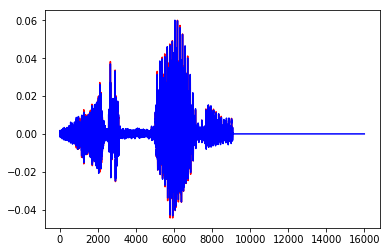

In [38]:
sAug = applyAllTfms(s,audio_tfms)
displayAudioData('augmented',sAug,s)

**IMPORTANT**: remember to **LISTEN** at the transformaiton ;-)

## Fine tune spectrogram

Specrogram should be configured properly: let's define a new function **tfm_spectro_tuned** with the parameters we wants, using partial application

In [39]:
#display(Image(tfm_spectro(ads[1],n_mels=128,to_db_scale=True))) #original
tfm_spectro_tuned = partial(tfm_spectro,n_mels=224, ws=200, n_fft=3200, to_db_scale=True)
display(Image(tfm_spectro_tuned(ads[1]))) #improved

In [40]:
#Replace the spectrogram transform with tfm_spectro_stft
tfms[0][-1]=tfm_spectro_tuned
tfms[1][-1]=tfm_spectro_tuned
tfms

([functools.partial(<function tfm_add_white_noise at 0x7faee532d9d8>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_modulate_volume at 0x7faee532da60>, noise_scl=0.001, lower_gain=0.95, upper_gain=1.05),
  functools.partial(<function tfm_pad_to_max at 0x7faee532dd90>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7faee5291158>, n_mels=224, ws=200, n_fft=3200, to_db_scale=True)],
 [functools.partial(<function tfm_pad_to_max at 0x7faee532dd90>, mx=16000),
  functools.partial(<function tfm_spectro at 0x7faee5291158>, n_mels=224, ws=200, n_fft=3200, to_db_scale=True)])

### DataBlock

In [41]:
#Create classes for all data!
classes = list(sorted(all_words_df.WRD.unique()))
len(classes), classes[:3]

(1800, ["'em", 'a', 'abbreviate'])

In [42]:
ils = AudioList.from_df(src, path, cols=['SampleAndSr'])

In [43]:
data = (ils
        .split_from_df('is_valid')
        .label_from_df('WRD', classes=classes)
        .transform(tfms)
        .databunch(bs=64)) # NOTE: 

### Take a look to some transformed examples

In [44]:
batch = data.one_batch()

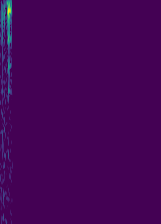

torch.Size([1, 224, 161])

'Corrisponding label: the'

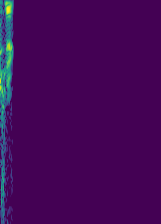

torch.Size([1, 224, 161])

'Corrisponding label: to'

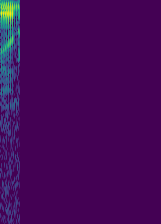

torch.Size([1, 224, 161])

'Corrisponding label: an'

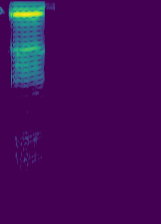

torch.Size([1, 224, 161])

'Corrisponding label: add'

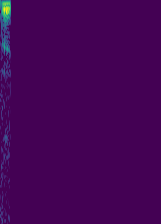

torch.Size([1, 224, 161])

'Corrisponding label: the'

In [45]:
#Try with more examples...
for i in range(5):
    img = batch[0][i]
    lbl = classes[batch[1][i]]
    display(Image(img),img.shape,f'Corrisponding label: {lbl}')

**IMPORTANT**: there is a lot of "silence" at the end of each sound...

## Learner

In [46]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [47]:
def adapt_first_layer(src_model, nChannels):
    '''
    Change first layer of network to accomodate new channels
    '''
    # save original
    original_weights = src_model[0][0].weight.clone()
    new_weights = original_weights[:,0:1,:,:]

    # create new layes
    new_layer = nn.Conv2d(nChannels,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    new_layer.weight = nn.Parameter(new_weights)

    # Replace layer and put to gpu.
    src_model[0][0] = new_layer
    src_model.cuda();

In [48]:
nChannels=1

# Alter existing model
adapt_first_layer(learn.model,nChannels)
print(f'First layer shape: {learn.model[0][0].weight.shape}')

First layer shape: torch.Size([64, 1, 7, 7])


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


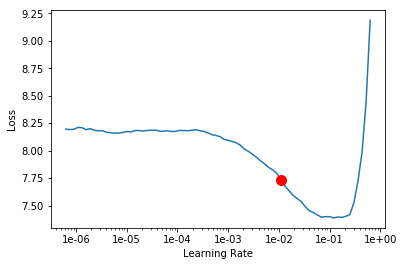

In [49]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,6.655325,6.035221,0.140411,00:23
1,5.668812,5.834116,0.159589,00:22
2,4.991372,5.578613,0.200685,00:22
3,4.107654,5.624647,0.230822,00:22
4,3.105548,6.065988,0.239041,00:22
5,2.099338,6.031009,0.263014,00:22
6,1.330667,6.091343,0.260959,00:22
7,0.949590,6.098113,0.263014,00:22


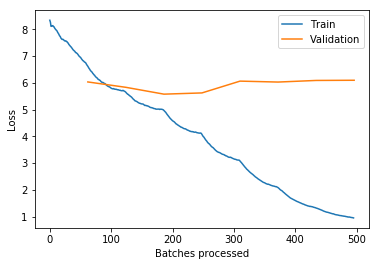

In [50]:
learn.fit_one_cycle(8, slice(1e-2))
learn.recorder.plot_losses()

In [51]:
#learn.save('pass1_all')

In [52]:
learn.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


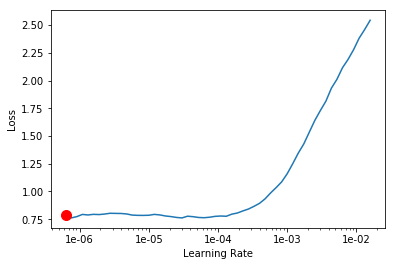

In [53]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.758982,6.066764,0.267808,00:25
1,0.751119,6.076657,0.266438,00:25
2,0.727683,6.049739,0.267123,00:25
3,0.733252,6.083566,0.267123,00:25
4,0.713201,6.050436,0.271918,00:25
5,0.696542,6.043192,0.270548,00:25
6,0.693567,6.032839,0.270548,00:25
7,0.686267,6.085218,0.265069,00:25


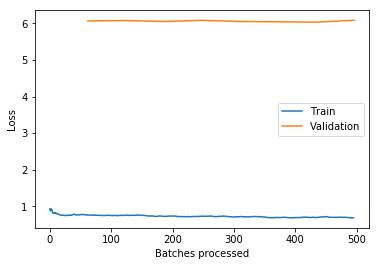

In [54]:
learn.fit_one_cycle(8, slice(2e-5))
learn.recorder.plot_losses()

In [55]:
#learn.save('pass2_all')

In [56]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


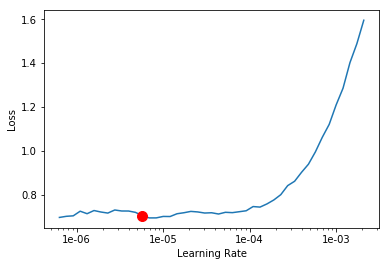

In [57]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.668424,6.039305,0.271918,00:28
1,0.659393,6.038344,0.271918,00:28
2,0.674952,6.002578,0.273288,00:28
3,0.672148,6.059895,0.276027,00:28
4,0.642335,6.047212,0.278082,00:28
5,0.625237,6.019510,0.273288,00:28
6,0.598847,6.027057,0.276712,00:28
7,0.607825,6.043840,0.274658,00:28


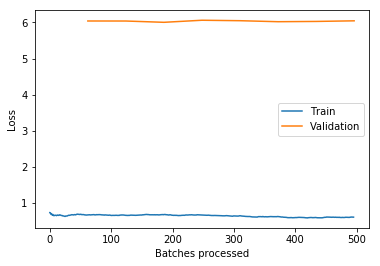

In [58]:
learn.fit_one_cycle(8, slice(1e-6,1e-5))
learn.recorder.plot_losses()

In [ ]:
#learn.save('pass3_all')

Not so good result: should work on it ;-)

## Fin.